In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression

In [4]:
placement_data = pd.read_csv('Placement_Data_Full_Class.csv')

In [5]:
placement_data

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


In [6]:
placement_data.gender.value_counts()

gender
M    139
F     76
Name: count, dtype: int64

In [7]:
placement_data.ssc_p.value_counts().sort_index(ascending=True)

ssc_p
40.89    1
41.00    1
43.00    1
44.00    1
45.00    1
        ..
85.80    1
86.50    1
87.00    3
88.00    1
89.40    1
Name: count, Length: 103, dtype: int64

In [8]:
placement_data.ssc_p.isna().value_counts()

ssc_p
False    215
Name: count, dtype: int64

In [9]:
placement_data.status.value_counts()

status
Placed        148
Not Placed     67
Name: count, dtype: int64

In [10]:
placement_data.salary.isna().value_counts()

salary
False    148
True      67
Name: count, dtype: int64

In [11]:
placement_data[(placement_data['salary'].isna()==False) & (placement_data['status']=='Not Placed')]

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary


In [12]:
placement_data.corr(numeric_only=True)

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
sl_no,1.000000,-0.078155,-0.085711,-0.088281,0.063636,0.022327,0.063764
ssc_p,-0.078155,1.000000,0.511472,0.538404,0.261993,0.388478,0.035330
hsc_p,-0.085711,0.511472,1.000000,0.434206,0.245113,0.354823,0.076819
degree_p,-0.088281,0.538404,0.434206,1.000000,0.224470,0.402364,-0.019272
etest_p,0.063636,0.261993,0.245113,0.224470,1.000000,0.218055,0.178307
mba_p,0.022327,0.388478,0.354823,0.402364,0.218055,1.000000,0.175013
salary,0.063764,0.035330,0.076819,-0.019272,0.178307,0.175013,1.000000


<Axes: >

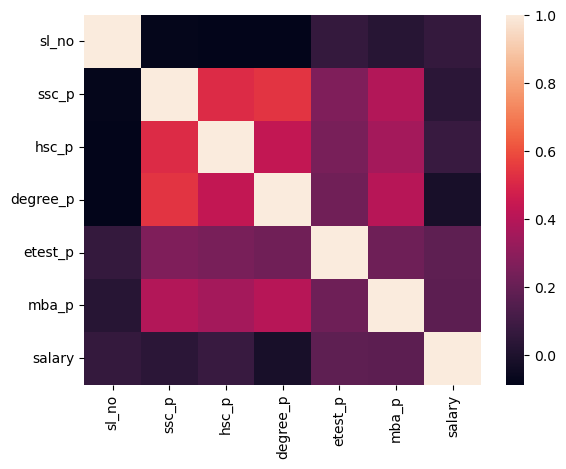

In [13]:
sns.heatmap(placement_data.corr(numeric_only=True))

None of the variables are too highly correlated. We have values where the correlations are at maximum .54 which is not alarming. Some correlation is ok, we don't have too high of correlation values so we do not have to remove any columns.

Our data is very limited, it doesn't make sense for us to do something like an 80 20 split for training data and testing data as it limits our ability to train our model to it's maximum potential. We can use LOOCV for training and testing our model

Training our model, we can try simple and complex models. A simple model like Logistic Regression can give us classification but it does not handle relationships between predictors too well, so I suspect something like a Random Forest or XG Boost model will do much better than Logistic Regression in giving a model that is able to accurately predict the placement status for individuals since we have predictors that are somewhat correlated in our data.

In [14]:
placement_data

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


In [15]:
x = placement_data.drop(['sl_no'],axis=1)

In [16]:
x

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


In [17]:
y = x.status

In [18]:
x = x.drop(labels=['status'], axis=1)

In [19]:
y

0          Placed
1          Placed
2          Placed
3      Not Placed
4          Placed
          ...    
210        Placed
211        Placed
212        Placed
213        Placed
214    Not Placed
Name: status, Length: 215, dtype: object

In [20]:
x

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,400000.0
211,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,275000.0
212,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,295000.0
213,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,204000.0


In [25]:
x[x['salary'].isnull()]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,NaN
5,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.00,Mkt&Fin,51.58,NaN
6,F,46.00,Others,49.20,Others,Commerce,79.00,Comm&Mgmt,No,74.28,Mkt&Fin,53.29,NaN
9,M,58.00,Central,70.00,Central,Commerce,61.00,Comm&Mgmt,No,54.00,Mkt&Fin,52.21,NaN
12,F,47.00,Central,55.00,Others,Science,65.00,Comm&Mgmt,No,62.00,Mkt&HR,65.04,NaN
14,M,62.00,Central,47.00,Central,Commerce,50.00,Comm&Mgmt,No,76.00,Mkt&HR,54.96,NaN
17,F,55.00,Central,67.00,Central,Commerce,64.00,Comm&Mgmt,No,60.00,Mkt&Fin,67.28,NaN
18,F,63.00,Central,66.00,Central,Commerce,64.00,Comm&Mgmt,No,68.00,Mkt&HR,64.08,NaN
25,F,52.58,Others,54.60,Central,Commerce,50.20,Comm&Mgmt,Yes,76.00,Mkt&Fin,65.33,NaN
29,M,62.00,Central,67.00,Central,Commerce,58.00,Comm&Mgmt,No,77.00,Mkt&Fin,51.29,NaN
